In [1]:
#!pip install scikit-image

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras import datasets, layers, models, regularizers, initializers, activations
from skimage.io import imshow
from skimage.transform import rotate

from skimage.io import imshow, imread
from skimage.transform import resize
from skimage.color import rgb2gray

np.random.seed(42)

In [4]:
fp = np.load("data/big/imgs.npz")

In [5]:
(_, cats), (_, dogs) = list( fp.items() )

In [6]:
imgs = np.vstack( ((cats/255).astype(np.float32), (dogs/255).astype(np.float32)) )

In [7]:
# these take up memory; clean them up if we can
del cats
del dogs

In [8]:
imgs.shape

(6000, 100, 100, 3)

In [12]:
# make target vector
y = np.array([1]*3000 + [0]*3000)

In [13]:
#shuffle images and target var
i = np.random.choice( np.arange(len(imgs)), size=len(imgs), replace=False)
imgs = imgs[i]
y = y[i]

In [14]:
# do train test split
n_train = int(len(imgs)*0.80)

X_train = imgs[:n_train]
y_train = y[:n_train]

X_test = imgs[n_train:]
y_test = y[n_train:]

In [104]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [105]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 64)        36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [106]:
1-y_test.mean()

0.5183333333333333

In [107]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid',
                      kernel_regularizer=regularizers.l2(0.003)))

In [108]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/10
4800/4800 [==============================] - 56s 12ms/sample - loss: 0.7027 - accuracy: 0.5312 - val_loss: 0.7022 - val_accuracy: 0.5375
Epoch 2/10
4800/4800 [==============================] - 56s 12ms/sample - loss: 0.6814 - accuracy: 0.5779 - val_loss: 0.6873 - val_accuracy: 0.5642
Epoch 3/10
4800/4800 [==============================] - 57s 12ms/sample - loss: 0.6523 - accuracy: 0.6240 - val_loss: 0.6622 - val_accuracy: 0.6175
Epoch 4/10
4800/4800 [==============================] - 60s 13ms/sample - loss: 0.6042 - accuracy: 0.6627 - val_loss: 0.6600 - val_accuracy: 0.6050
Epoch 5/10
4800/4800 [==============================] - 57s 12ms/sample - loss: 0.5436 - accuracy: 0.7129 - val_loss: 0.6571 - val_accuracy: 0.6333
Epoch 6/10
4800/4800 [==============================] - 60s 13ms/sample - loss: 0.4505 - accuracy: 0.7767 - val_loss: 0.7711 - val_accuracy: 0.6283
Epoch 7/10
4800/4800 [==============================] - 59s 12ms

## Explore the ouputs of each layer

In [199]:
i = 10
last_img = X_test[i:i+1]

In [200]:
layer_output = [last_img.astype(np.float32)]

In [201]:
for layer in model.layers:
    output = layer(layer_output[-1])
    layer_output.append( output )

## Input

A single image

In [202]:
layer_output[0].shape

(1, 100, 100, 3)

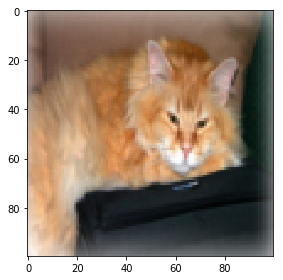

In [203]:
imshow( layer_output[0][0,:,:] )

## Layer 1: stack of convolutions

32 3x3 convolutional kernals, resulting in 32 channels.

In [204]:
layer_output[1].shape

TensorShape([1, 98, 98, 32])

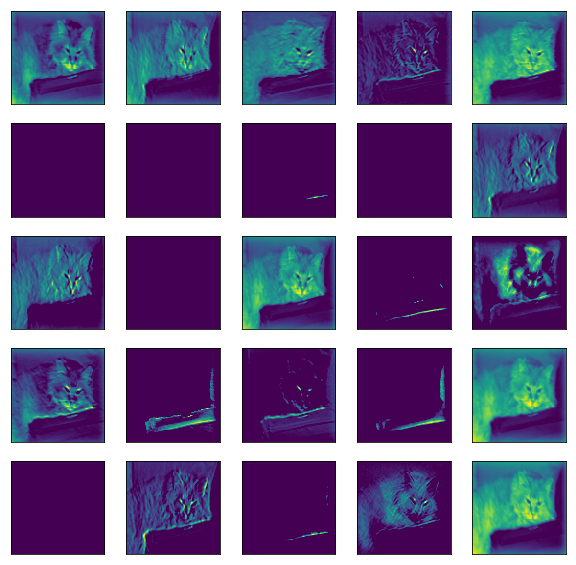

In [205]:
nrows, ncols = 5,5
fig, axs = plt.subplots(nrows,ncols,  figsize=(10,10))

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i][j]
        ax.imshow( layer_output[1][0,:,:,i*ncols+j] )
        ax.set_xticks([])
        ax.set_yticks([])

This layer has learned several 3x3 kernals. We can fetch them using the `get_weights` method of the layer:

In [206]:
W, b = model.layers[0].get_weights()
W.shape

(3, 3, 3, 32)

Note the shape of the kernal `ndarray` is `(kernal_width, kernal_height, input_channels, n_kernals)`. Because the input is a black-and-white image, the number of input channels is `1`.

## Layer 2: max pool

In [207]:
layer_output[2].shape

TensorShape([1, 49, 49, 32])

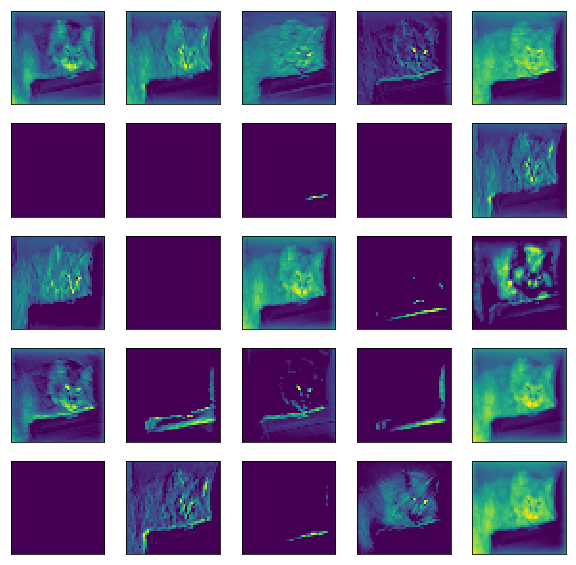

In [208]:
nrows, ncols = 5,5
fig, axs = plt.subplots(nrows,ncols,  figsize=(10,10))

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i][j]
        ax.imshow( layer_output[2][0,:,:,i*ncols+j] )
        ax.set_xticks([])
        ax.set_yticks([])

## Layer 3: stack of 64 3x3 convolutions

Because there are 64 convolutional kernals in this layer, there will be 64 channels of output

In [209]:
layer_output[3].shape

TensorShape([1, 47, 47, 64])

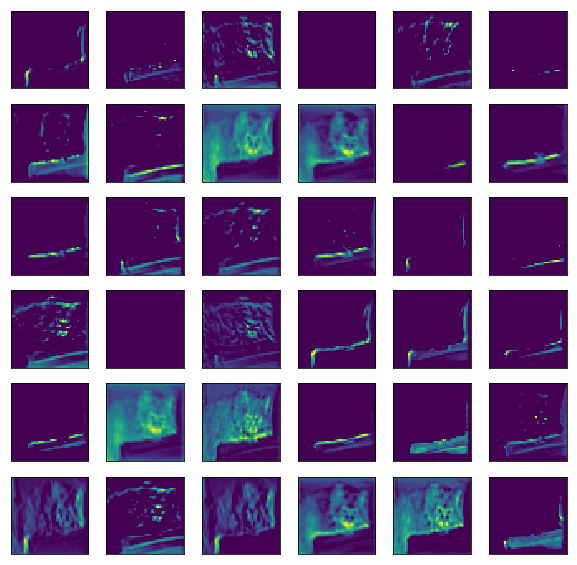

In [210]:
nrows, ncols = 6,6
fig, axs = plt.subplots(nrows,ncols,  figsize=(10,10))

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i][j]
        ax.imshow( layer_output[3][0,:,:,i*ncols+j] )
        ax.set_xticks([])
        ax.set_yticks([])

If we fetch the convolutional kernals in this layer, we see that each 3x3 kernal is actually an `ndarray` with shape `(3,3,32)`, because it is operating on an 32-channel input. The input has 32 channels because the preceding layer output `32` channels - one corresponding to each kernal in the first convolutional layer.

In [211]:
W, b = model.layers[2].get_weights()

W.shape

(3, 3, 32, 64)

Here's one kernel.

In [212]:
first_kernel = W[:,:,:,0]
first_kernel

array([[[ 0.04984794,  0.1452125 ,  0.03690483, -0.05370265,
         -0.03858941, -0.01079275,  0.05148377, -0.05400246,
         -0.01644801,  0.07634163, -0.04881976,  0.0556315 ,
          0.07953791,  0.03885612, -0.0741464 , -0.02808264,
         -0.08091925, -0.12786582, -0.00323268,  0.11734764,
          0.01779955,  0.1808547 ,  0.08346721,  0.09839433,
          0.04856296,  0.12815326,  0.08708694,  0.06896555,
          0.02625795,  0.12259427, -0.01487466,  0.11339907],
        [ 0.09027152,  0.06528274, -0.08991516,  0.0189836 ,
          0.05931426,  0.10492742,  0.025827  ,  0.01965807,
          0.02411782,  0.08144242, -0.00275742,  0.0165033 ,
          0.00899918,  0.06007683,  0.02284643,  0.04641056,
          0.02368412, -0.07011949,  0.01085511, -0.07211408,
          0.11706327,  0.2326011 ,  0.05442615,  0.11516035,
          0.02531151, -0.01138664,  0.0378401 , -0.06353092,
          0.06256826, -0.14824897, -0.10727509,  0.12863351],
        [ 0.03341753, 

If we grab a 3-pixel-wide by 3-pixel-tall chunk of the upper-lefthand corner of the preceding layer, grabbing every channel at once:

In [213]:
layer_3_chunk = layer_output[2].numpy()[0, 0:3, 0:3, :]
layer_3_chunk

array([[[5.1558149e-01, 3.2372871e-01, 1.5667313e-01, 4.2123213e-02,
         3.6550441e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 2.0446870e-01, 5.4478321e-02, 0.0000000e+00,
         4.1501933e-01, 0.0000000e+00, 0.0000000e+00, 2.0044211e-01,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 7.3531741e-01,
         0.0000000e+00, 9.1598064e-02, 0.0000000e+00, 0.0000000e+00,
         6.4266723e-01, 9.5241770e-02, 1.1209767e-01, 4.5953631e-01,
         0.0000000e+00, 0.0000000e+00, 7.2424060e-01, 0.0000000e+00],
        [4.3679291e-01, 2.8801399e-01, 1.3040830e-01, 4.3051880e-02,
         3.3911142e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 1.8517172e-01, 4.6906915e-02, 0.0000000e+00,
         3.6939085e-01, 0.0000000e+00, 0.0000000e+00, 1.8406457e-01,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 6.4684743e-01,
         0.0000000e+00, 8.4221572e-02, 0.0000000e+00, 0.0000000e+00,
         5.7893550e-01, 8.4009603

Note the kernel and a cross-sectional-chunk of the preceding layer have the same shape.

In [214]:
first_kernel.shape, layer_3_chunk.shape

((3, 3, 32), (3, 3, 32))

Thus they can be pairwise-multiplied and summed. This is essentially the convolution function, slid across every position in the preceding layer's output.

In [215]:
(first_kernel * layer_3_chunk).sum()

-0.22841048

## Layer 4: maxpool


In [216]:
layer_output[4].shape

TensorShape([1, 23, 23, 64])

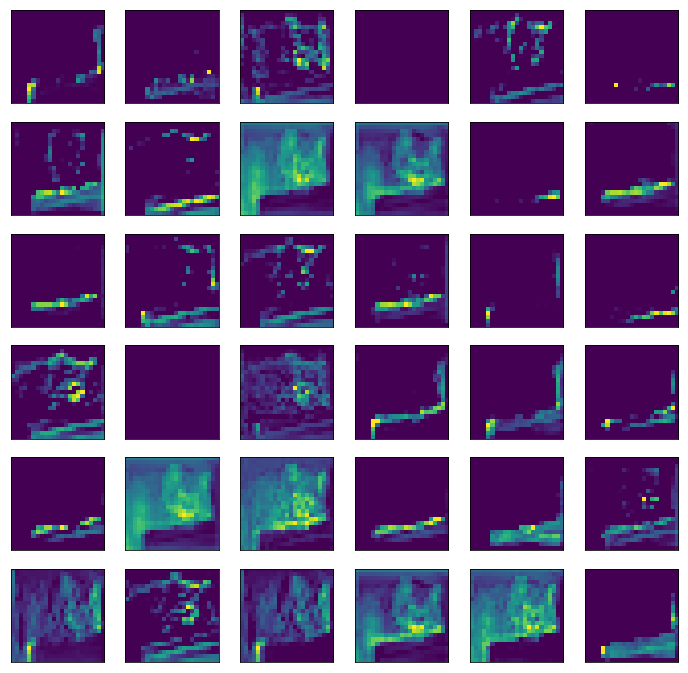

In [217]:
nrows, ncols = 6,6
fig, axs = plt.subplots(nrows,ncols,  figsize=(12,12))

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i][j]
        ax.imshow( layer_output[4][0,:,:,i*ncols+j] )
        ax.set_xticks([])
        ax.set_yticks([])

## Layer 5: another stack of 64 3x3 convolutions

In [218]:
layer_output[5].shape

TensorShape([1, 21, 21, 64])

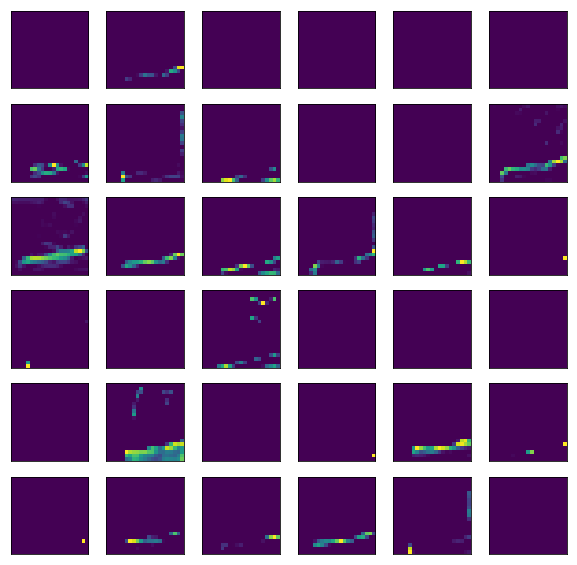

In [219]:
nrows, ncols = 6,6
fig, axs = plt.subplots(nrows,ncols,  figsize=(10,10))

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i][j]
        ax.imshow( layer_output[5][0,:,:,i*ncols+j] )
        ax.set_xticks([])
        ax.set_yticks([])

Once again we have four convolutional kernals, which span a 3x3 section of images across, in this case, **9** input channels.

In [220]:
W, b = model.layers[4].get_weights()

W.shape

(3, 3, 64, 64)

Classical image analysis involves
1. Applying filters to an image
2. Flattening the resulting image to produce a sample vector $\vec{x}_i$ of features for that image.
3. Using classical machine learning techniques on the resulting featurization.

Convolutional neural networks are divided into two sections:

1. A "filter" section, which outputs a fancy output "image" filled with pixels that turn out to be good discriminators. This filter is learned.
2. A "classical machine learning" step, in the form of single- or multi-layer perceptron.

The convolution/maxpool steps are the "filter" section. The output "image" is basically all the channels output from the last convolution step glued together:

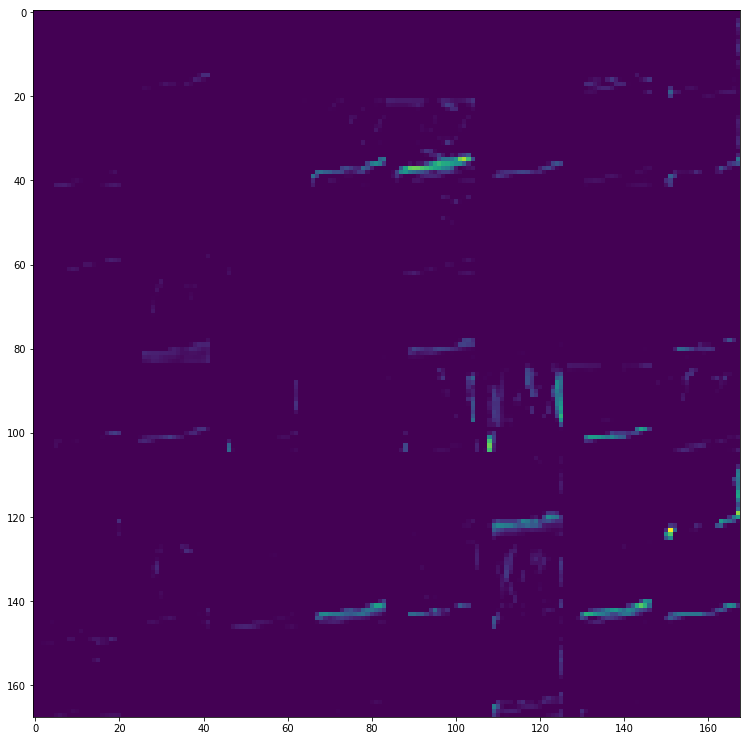

In [221]:
foo = layer_output[5].numpy()

rowstrips = []
for i in range(8):
    rowstrips.append( np.hstack( foo[0,:,:,i*8:(i+1)*8].transpose(2,0,1) ) )

fig, ax = plt.subplots(1, figsize=(13,13))
ax.imshow( np.vstack( rowstrips ) )

## Layer 6: flatten

The 8th layer simply flattens the last convolution layer. The resulting matrix has shape `(n_samples, n_features)`.

In [222]:
layer_output[6].shape

TensorShape([1, 28224])

In principle one could simply take this matrix and train a random forest, or any other supervised model. Traditionally, we complete the model with a multiplayer perceptron.

## Layer 7: densely connected neural layer

This hidden perceptron layer has 64 neurons, each with 28224 connections to every pixel in the previous layer.

In [223]:
W, b = model.layers[6].get_weights()
W.shape

(28224, 64)

To find the activation of the 0th neuron, for example, get the weight of each connection:

In [224]:
neuron0_weights = W[:,0]
neuron0_weights

array([-0.00329503,  0.00706448,  0.00987814, ...,  0.00912537,
       -0.01088568, -0.01437379], dtype=float32)

Take the dot product against all the pixels output from the "image filter" stage (flattened, of course). A bias terms was also learned by the convnet.

In [225]:
neuron0_activation = neuron0_weights.dot( layer_output[6][0] ) + b[0]
neuron0_activation

-7.6884146

The activation is the excitation of the neuron passed through an activation function:

In [226]:
activations.relu( neuron0_activation ).numpy()

0.0

To do this all at once, just apply the weights and biases via this handy equation:

$$\phi( X W + b )$$

where $\phi$ is the activation function.

In [227]:
activations.relu( layer_output[6].numpy() @ W + b ).numpy()

array([[ 0.        ,  8.882624  ,  0.        , 11.611105  ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.17140476,  0.        ,
         3.8290842 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  7.1411543 ,  0.        ,  0.        ,
         0.4787601 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  5.6421757 ,
         0.        ,  1.9109871 ,  0.        ,  0.        ,  0.        ,
         0.14309171,  0.        ,  0.        ,  0.        ,  0.        ,
        21.25086   ,  0.        ,  0.        ,  1.5609952 ,  0.        ,
         3.3146622 ,  2.3152068 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  4.2868752 ,  0.        ]],
      dtype=float32)

In doing that we've reproduced the work of the densely connected layer:

In [228]:
layer_output[7].numpy()

array([[ 0.        ,  8.88262   ,  0.        , 11.611112  ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.17140588,  0.        ,
         3.8290856 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  7.14115   ,  0.        ,  0.        ,
         0.47876054,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  5.6421785 ,
         0.        ,  1.910988  ,  0.        ,  0.        ,  0.        ,
         0.14309308,  0.        ,  0.        ,  0.        ,  0.        ,
        21.250858  ,  0.        ,  0.        ,  1.5609947 ,  0.        ,
         3.3146627 ,  2.315206  ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  4.2868752 ,  0.        ]],
      dtype=float32)

## Layer 8: logistic regression

The last layer is simply logistic regression:

In [229]:
W, b = model.layers[7].get_weights()

In [230]:
W.flatten(), b[0]

(array([-1.18761966e-02,  2.11754590e-01,  5.59954681e-02, -1.47941411e-01,
        -3.22186083e-01,  1.76165357e-01, -5.49569504e-12, -7.93662150e-11,
         1.69809714e-01,  2.53601372e-01,  3.25309992e-01, -3.12612504e-01,
        -1.77062750e-01,  1.85410514e-01, -8.05608928e-04, -2.68893808e-01,
        -2.28674740e-01, -2.38134280e-01,  1.49321094e-01,  1.21541731e-01,
        -2.00070813e-01, -2.03962535e-01, -2.01711595e-01,  1.88430324e-01,
         2.58448720e-01,  2.08419770e-01,  7.86028100e-12,  4.96075228e-02,
         9.21044722e-02, -4.09315946e-03,  7.39595741e-02,  7.31266954e-33,
        -1.75133869e-01, -1.49533570e-01,  8.98736108e-09, -2.86859185e-01,
         1.36982456e-01, -1.93721488e-01, -2.27058604e-01,  2.39650831e-01,
         1.47697715e-33,  1.85946926e-01, -2.43613109e-01,  1.06571749e-01,
        -5.75746931e-02,  1.29677087e-01,  2.42402330e-01,  1.75068080e-01,
        -2.72624969e-01,  8.82850390e-12, -7.45338798e-02,  2.52218574e-01,
        -2.1

It's simply $sigmoid( XW+b )$

In [231]:
activations.sigmoid( W.flatten().dot( layer_output[7].numpy().flatten() ) + b.flatten() )

<tf.Tensor: id=40977, shape=(1,), dtype=float32, numpy=array([0.15455456], dtype=float32)>

This is the output of the final layer:

In [232]:
layer_output[8].numpy()

array([[0.15455456]], dtype=float32)

In [233]:
yhat = (model.predict( X_test ).flatten()>0.5).astype(int)

In [234]:
(y_test == yhat).mean()

0.6483333333333333

In [159]:
1-y_test.mean()

0.5183333333333333